In [24]:
from espei.datasets import load_datasets
from espei.error_functions.context import setup_context
from espei.error_functions.zpf_error import calculate_zpf_error
from pycalphad import Database
from glob import glob
import numpy as np

ds = load_datasets(glob('2020-05-28-Cr-Ni-ZPF/input-data/run/ZPF/*.json'))
#ds = load_datasets(['UQ/Cr-Ni-run/run/ZPF/CR-NI-ZPF-BCC_A2-FCC_A1-zhang2014impurity.json'])
dbf = Database('dft.tdb')
dbf.elements = ['CR', 'NI', 'VA'] # workaround issue with callables of subsystem
ctx = setup_context(dbf, ds)
# weight from YAML file
ctx['zpf_kwargs']['data_weight'] = 20.0
# shape: chain, sample, param_symbol
param_trace = np.load('2020-05-28-Cr-Ni-ZPF/trace-zpf.npy')
print('param_trace.shape', param_trace.shape)
#lnprob = np.load('UQ/Cr-Ni-run/2020-05-28-Cr-Ni-ZPF/lnprob.npy')
lnprob_zpf = np.load('2020-05-28-Cr-Ni-ZPF/lnprob-zpf.npy')
print('lnprob_zpf.shape', lnprob_zpf.shape)

param_trace.shape (24, 50, 12)
lnprob_zpf.shape (24, 50)


In [25]:
from tqdm.auto import tqdm
parameter_trials = []
# chain, sample, dataset, param_symbol
calc_lnprob = np.zeros((1,50,len(ds)))
calc_lnprobgrad = np.zeros((1,50,len(ds),param_trace.shape[2]))
#calc_lnprob = np.load('UQ/Cr-Ni-run/2020-05-27-lnprob-allzpf.npy')
#calc_lnprobgrad = np.load('UQ/Cr-Ni-run/2020-05-27-lnprobgrad-allzpf.npy')

for chain_idx in [0]:#tqdm(range(calc_lnprob.shape[0]), desc='Chains'):
    for iter_idx in tqdm(range(50), desc='Samples'):
        zpf_prob_error, zpf_prob_error_gradient = calculate_zpf_error(parameters=param_trace[chain_idx, iter_idx, :],
                                                                      **ctx.get('zpf_kwargs'))
        calc_lnprob[chain_idx, iter_idx, :] = zpf_prob_error
        calc_lnprobgrad[chain_idx, iter_idx, :, :] = np.array(zpf_prob_error_gradient)

Text(0.5, 1.0, 'Cr-Ni Chain 0 Trial 49')

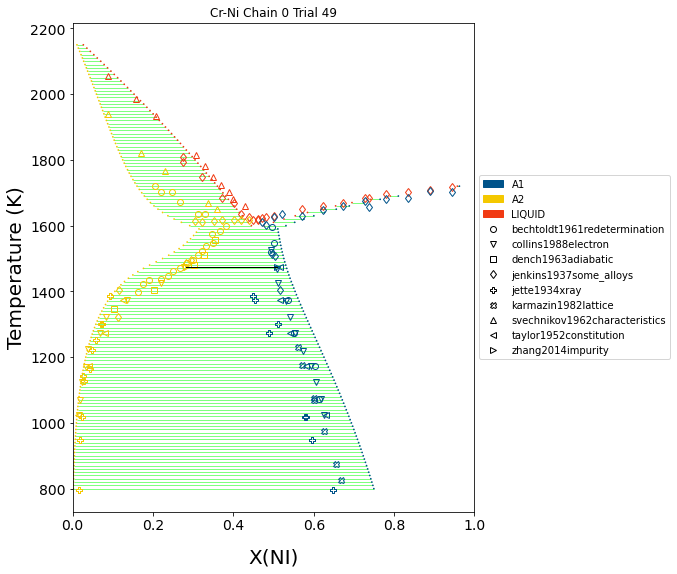

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from espei.plot import dataplot
from pycalphad import variables as v
from pycalphad import binplot
from pycalphad.core.solver import InteriorPointSolver, SundmanSolver

fig = plt.figure(figsize=(9,9))
ax = fig.gca()
trial = 49
chain = 0
binplot(dbf, ['CR', 'NI', 'VA'], ['A1','A2', 'LIQUID'], {v.P: 101325, v.T: (800, 2200, 10), v.X('NI'): (0,1,0.02), v.N:1},
        plot_kwargs={'ax': ax},
        eq_kwargs={'solver': SundmanSolver(),
                   'parameters': dict(zip(ctx['symbols_to_fit'], param_trace[chain, trial, :]))})
dataplot(['CR', 'NI', 'VA'], ['A1', 'A2', 'LIQUID'], {v.P: 101325, v.T: (1,1,1), v.X('NI'): (1, 1, 1)}, ds, ax=ax)
ax.set_title(f'Cr-Ni Chain {chain} Trial {trial}')

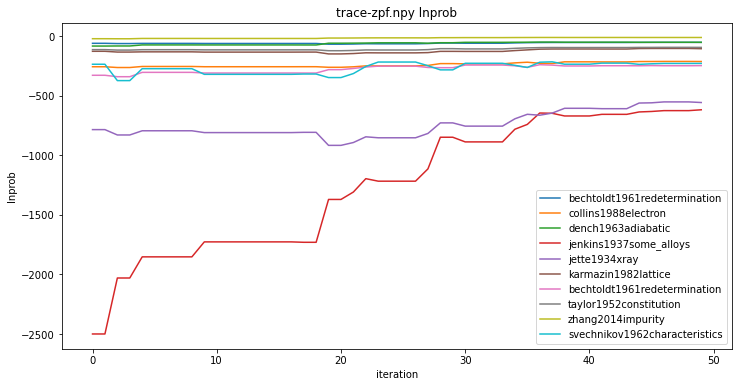

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    ax.plot(np.arange(50), calc_lnprob[0, :, data_idx], label=dataset['dataset_reference'])
ax.set_xlabel('iteration')
ax.set_ylabel('lnprob')
ax.set_title('trace-zpf.npy lnprob')
ax.legend()

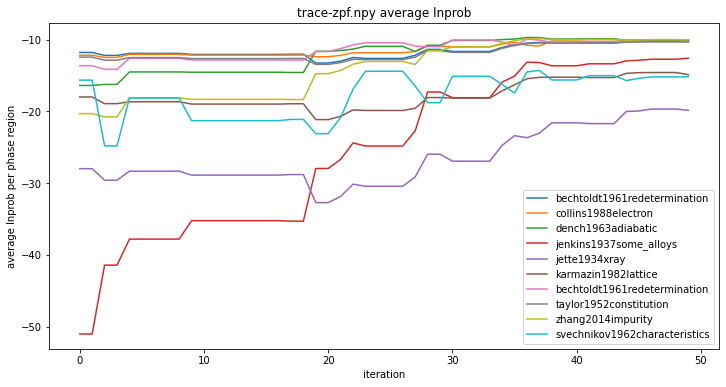

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    num_phase_regions = len(dataset['phase_regions'])
    ax.plot(np.arange(50), calc_lnprob[0, :, data_idx] / num_phase_regions, label=dataset['dataset_reference'])
ax.set_xlabel('iteration')
ax.set_ylabel('average lnprob per phase region')
ax.set_title('trace-zpf.npy average lnprob')
ax.legend()

Text(0, 0.5, 'lnprob')

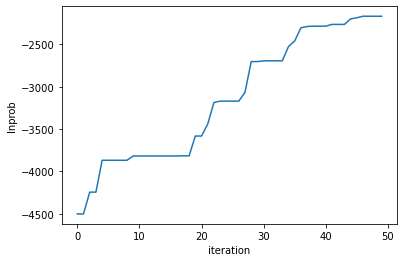

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
for chain_idx in [0]:
    plt.plot(np.arange(50), calc_lnprob[chain_idx, :, :].sum(axis=-1))
plt.xlabel('iteration')
plt.ylabel('lnprob')

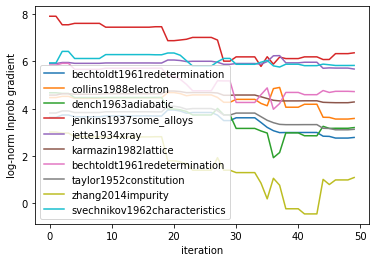

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    plt.plot(np.arange(50), np.log(np.linalg.norm(calc_lnprobgrad[0, :, data_idx, :], axis=-1)), label=dataset['dataset_reference'])
plt.xlabel('iteration')
plt.ylabel('log-norm lnprob gradient')
plt.legend()

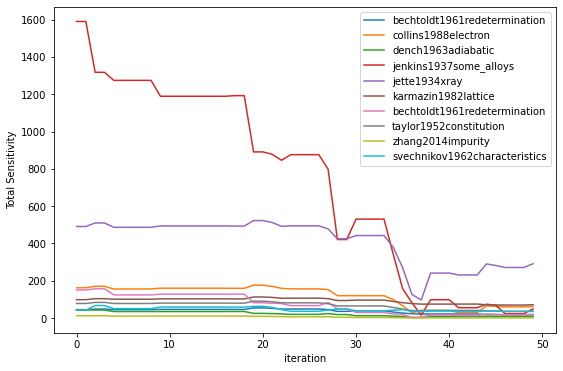

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
trace_param_std = np.std(param_trace[0, :, :], axis=0)
tdbdb_param_std = 0 # TODO
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    ax.plot(np.arange(50), np.abs(calc_lnprobgrad[0, :, data_idx, :].dot(trace_param_std)), label=dataset['dataset_reference'])
ax.set_xlabel('iteration')
ax.set_ylabel('Total Sensitivity')
ax.legend()

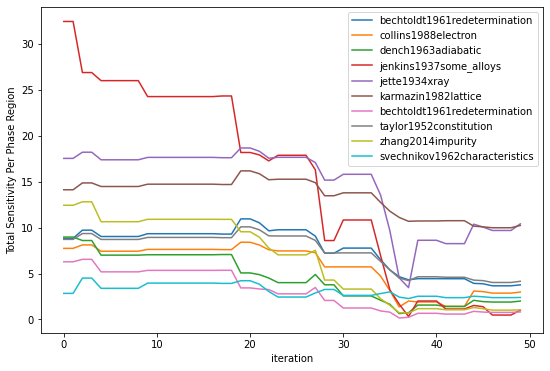

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
trace_param_std = np.std(param_trace[0, :, :], axis=0)
tdbdb_param_std = 0 # TODO
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    num_phase_regions = len(dataset['phase_regions'])
    ax.plot(np.arange(50), np.abs(calc_lnprobgrad[0, :, data_idx, :].dot(trace_param_std)) / num_phase_regions,
            label=dataset['dataset_reference'])
ax.set_xlabel('iteration')
ax.set_ylabel('Total Sensitivity Per Phase Region')
ax.legend()

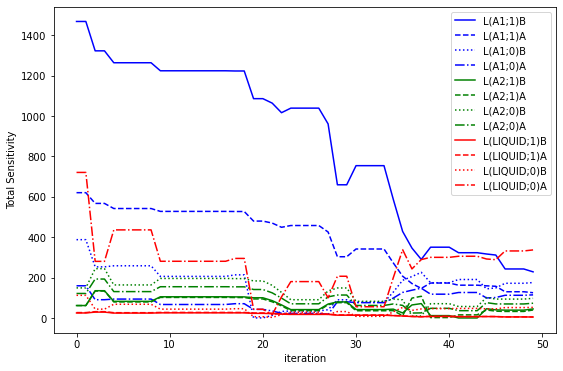

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from cycler import cycler
"""
PARAMETER L(A1,CR,NI;0) 1 T*VV0002# + VV0003#; 10000 N !
PARAMETER L(A1,CR,NI;1) 1 T*VV0000# + VV0001#; 10000 N !
PARAMETER L(A2,CR,NI;0) 1 T*VV0006# + VV0007#; 10000 N !
PARAMETER L(A2,CR,NI;1) 1 T*VV0004# + VV0005#; 10000 N !
PARAMETER L(LIQUID,CR,NI;0) 1 T*VV0010# + VV0011#; 10000 N !
PARAMETER L(LIQUID,CR,NI;1) 1 T*VV0008# + VV0009#; 10000 N !
"""
param_symbol_labels = {
'VV0000': 'L(A1;1)B',
'VV0001': 'L(A1;1)A',
'VV0002': 'L(A1;0)B',
'VV0003': 'L(A1;0)A',
'VV0004': 'L(A2;1)B',
'VV0005': 'L(A2;1)A',
'VV0006': 'L(A2;0)B',
'VV0007': 'L(A2;0)A',
'VV0008': 'L(LIQUID;1)B',
'VV0009': 'L(LIQUID;1)A',
'VV0010': 'L(LIQUID;0)B',
'VV0011': 'L(LIQUID;0)A'
}
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
custom_cycler = (cycler(color='bgrcmyk') *
                 cycler(linestyle=['-', '--', ':', '-.']))
ax.set_prop_cycle(custom_cycler)
trace_param_std = np.std(param_trace[0, :, :], axis=0)
tdbdb_param_std = 0 # TODO
total_calc_lnprobgrad = np.sum(calc_lnprobgrad[0, :, :, :], axis=1)
total_calc_sensitivity = total_calc_lnprobgrad * trace_param_std
for param_idx, param_symbol in enumerate(ctx['symbols_to_fit']):
    ax.plot(np.arange(50), np.abs(total_calc_sensitivity[:, param_idx]), label=param_symbol_labels[param_symbol])

ax.set_xlabel('iteration')
ax.set_ylabel('Total Sensitivity')
ax.legend()

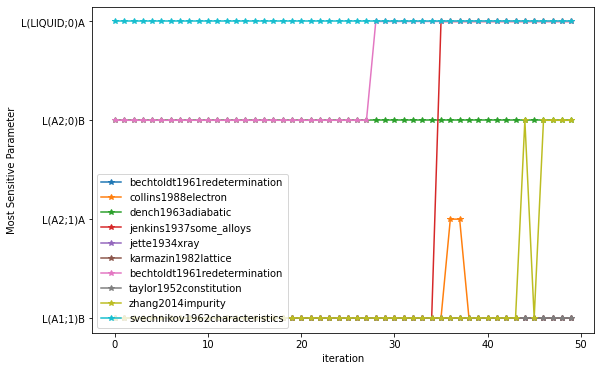

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
trace_param_std = np.std(param_trace[0, :, :], axis=0)
tdbdb_param_std = 0 # TODO
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    sensitivities = np.abs(calc_lnprobgrad[0, :, data_idx, :]) * trace_param_std[np.newaxis, :]
    arg_sensitivities = np.argmax(sensitivities, axis=1)
    param_sensitivities = [param_symbol_labels[ctx['symbols_to_fit'][i]] for i in arg_sensitivities]
    ax.plot(np.arange(50), param_sensitivities, label=dataset['dataset_reference'], marker='*')
ax.set_xlabel('iteration')
ax.set_ylabel('Most Sensitive Parameter')
ax.legend(loc='lower left')